In [1]:
# Attempt to claasify hand-written digits from well-known MNIST data.
# Of course we first need to load and familiarize with data.
# Note: MNIST data is quite popular and available from many sources, pesonally I got it (together with
# data description) from Kaggle.
#
# From data description:
#
# Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. 
# Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, 
# with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.
#
# The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn
# by the user. The rest of the columns contain the pixel-values of the associated image.
#
# Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. 
# To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers
# between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
#
# The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.
#
# Work schedule:
# * Loading/preparing data
# * Attempt to classification using SVM
# * Another try to classification - using neural network (possibly own implementation)
#   to compare results.

In [2]:
# Modules import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Loading data
train_set_path = 'input/train.csv'
test_set_path = 'input/test.csv'

train_data = pd.read_csv(train_set_path)
test_data = pd.read_csv(test_set_path)

In [4]:
# Let's chceck if there is any missing data
# In standard cases I would use info method but since we have above 780
# columns let's check it another way
len(train_data) == len(train_data.dropna(axis=0, how='any'))

True

In [5]:
# Looking good, there are no nulls in data.
# Before classification attempts we need to transform dataframe into
# numpy array.
train_labels = train_data['label'].values
train_data = train_data.drop('label', axis=1).values

In [ ]:
# Let's take a look at actual digit
plt.imshow(train_data[1].reshape(28, -1), cmap='gray')
plt.show()

In [ ]:
# Color inversion - just for eventual digits showing purposes
# train_data = 255 - train_data
# test_data = 255 - test_data

In [6]:
# Anyway, we were able to actually reproduce image from data and we no missing
# data in set so let's move to the actual predicting.
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [7]:
# But first we need a little data split for model evaluation purposes
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.17, random_state=0)

In [8]:
# Training classifier
classifier = SVC(kernel='rbf')
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
# Let's see how our model will work on new data
classifier.score(X_test, y_test)

0.11300938243943426

In [10]:
# Well, the result is rather bad, not to say terrible.
# The reason probly is to low data amount for used value range (0 - 255).
# Let's try to use classifier with a binarized data.
train_data[train_data > 0] = 1
test_data[test_data > 0] = 1

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.17, random_state=0)

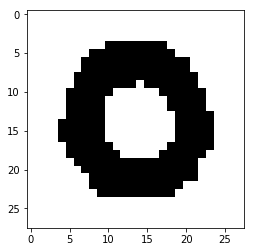

In [11]:
# Quick binarization correctness check
plt.imshow(train_data[1].reshape(28, -1), cmap='binary') 
# Note: with binary cmap colors are reversed to the ones that we had earlier 
plt.show()

In [12]:
# Ok, now that is data is completly binarized let's retrain our classifier
classifier = SVC(kernel='rbf')
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
classifier.score(X_test, y_test)

0.94272510852821734

In [ ]:
# Well results are definitely better - over 94% is rather nice result.
# But in this task neural networks tends to achieve even better results.
# Instead one implementing one from scratch we will use Keras (user friendly library
# for neural networks). Note that tensorflow backend was used, in case of Theano there
# may be some problems with code.

In [14]:
# That being said, let's start with part 2 - neural networks attempt:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # keras one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [15]:
# Data sources paths
train_file = "input/train.csv"
test_file = "input/test.csv"

In [16]:
# Loading data and split into train/validation set
train_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
X_train, X_validate, y_train, y_validate = train_test_split(
    train_data[:, 1:], train_data[:, 0], test_size=0.1)

In [17]:
# Reshaping data - note that we will use pixel surroundings for features detection,
# and special last dimension (for number of channels, required by keras.
X_train = X_train.reshape(-1, 28, 28, 1)
X_validate = X_validate.reshape(-1, 28, 28, 1)

In [18]:
# Data standarization, will make net converge faster
X_train = X_train.astype("float32") / 255.
X_validate = X_validate.astype("float32") / 255.

In [19]:
# One hot encoding of results
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

In [20]:
# Sample after encoding
print(y_train[0])

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [21]:
# Start of model creation
# Model description:
# Model is sequential, we place on layer at a time.
# Conv2D - convolutional layers (most important part of our network),
# we have 16-32 filters that use nine (look up kernel size) weights each to transform a pixel
# to a weighted average of itself and its eight neighbors.
# The same nine weights are used over the whole image - so the net will pick up features that are useful everywhere.
# Additionaly, with that size of kernel, we can stack many convolutional layers on top of each other without
# running out of memory/time.
# MaxPooling layers just look at four neighboring pixels and picks the maximal value.
# This reduces the size of the image (by half), and by combining convolutional and pooling layers,
# the net be able to combine its features to learn more global features of the image.
# In the end features are used in two fully-connected (Dense) layers.
# Batch Normalization is a technical trick to make training faster.
# Dropout is a regularization method, where the layer randomly replaces a proportion of its weights
# to zero for each training sample. This forces the net to learn features in a distributed way,
# not relying to much on a particular weight, and therefore improves generalization.
# 'relu' is the activation function x -> max(x,0).

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu',
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

In [24]:
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

In [25]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [27]:
# Another important method to improve generalization is augmentation.
# This means generating more training data by randomly perturbing the images.
# If done in the right way, it can force the net to only learn translation-invariant features.
# When training model with over hundreds of epochs, augmentation will definitely improve performance.
data_generator = ImageDataGenerator(zoom_range=0.1,
                            height_shift_range=0.1,
                            width_shift_range=0.1,
                            rotation_range=10)

In [28]:
# Model compilation needs to be done before any learning
# loss - specification of used cost/lost function
# optimizer - as the name says, most popular is SGD, Adam works similar but is faster
# metrics - for evaluation purposes
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-5), metrics=["accuracy"])

In [29]:
# First, train once with a smaller learning rate to ensure convergence
hist = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=16),
                           steps_per_epoch=1000,
                           epochs=1, verbose=0)

In [30]:
# Actual training. Note: models are not overfitted since the validation data
# is not used in the fitting process (stated in Keras documentation), but for monitoring
# of learning process - returned hist (history) shows our learning process.
# For speeding up, amount of validation data used can be lowered.
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-4), metrics=["accuracy"])
hist = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=16),
                           steps_per_epoch=1000,
                           epochs=20,
                           verbose=2, # each epoch stats will be printed out
                           validation_data=(X_validate[:, :], y_validate[:, :]))

Epoch 1/20
51s - loss: 0.5987 - acc: 0.8013 - val_loss: 0.0961 - val_acc: 0.9660
Epoch 2/20
49s - loss: 0.2671 - acc: 0.9163 - val_loss: 0.0815 - val_acc: 0.9712
Epoch 3/20
48s - loss: 0.2035 - acc: 0.9376 - val_loss: 0.0562 - val_acc: 0.9814
Epoch 4/20
50s - loss: 0.1675 - acc: 0.9474 - val_loss: 0.0427 - val_acc: 0.9869
Epoch 5/20
48s - loss: 0.1525 - acc: 0.9540 - val_loss: 0.0502 - val_acc: 0.9838
Epoch 6/20
48s - loss: 0.1416 - acc: 0.9581 - val_loss: 0.0398 - val_acc: 0.9883
Epoch 7/20
48s - loss: 0.1375 - acc: 0.9590 - val_loss: 0.0333 - val_acc: 0.9871
Epoch 8/20
47s - loss: 0.1249 - acc: 0.9619 - val_loss: 0.0288 - val_acc: 0.9900
Epoch 9/20
47s - loss: 0.1187 - acc: 0.9659 - val_loss: 0.0343 - val_acc: 0.9869
Epoch 10/20
49s - loss: 0.1064 - acc: 0.9667 - val_loss: 0.0357 - val_acc: 0.9867
Epoch 11/20
47s - loss: 0.1046 - acc: 0.9692 - val_loss: 0.0401 - val_acc: 0.9857
Epoch 12/20
47s - loss: 0.1016 - acc: 0.9696 - val_loss: 0.0282 - val_acc: 0.9905
Epoch 13/20
48s - loss: 0

In [31]:
# Evaluation based on validation set
final_loss, final_acc = model.evaluate(X_validate, y_validate, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0232, final accuracy: 0.9921


In [33]:
# Confusion matrix based on validation set
y_pred = model.predict(X_validate)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validate, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[431   0   0   0   0   0   0   0   0   0]
 [  0 459   0   0   1   0   0   0   0   0]
 [  1   0 410   1   0   0   0   0   0   0]
 [  0   0   0 432   0   1   0   0   0   0]
 [  0   0   0   0 400   0   0   3   0   6]
 [  1   0   0   0   0 395   3   1   0   0]
 [  1   0   0   0   1   0 420   0   0   0]
 [  0   2   3   0   0   0   0 428   0   0]
 [  1   0   1   0   0   0   1   1 386   1]
 [  0   1   0   0   1   0   0   1   0 406]]


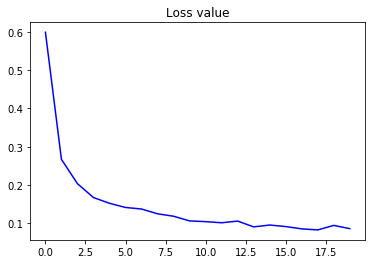

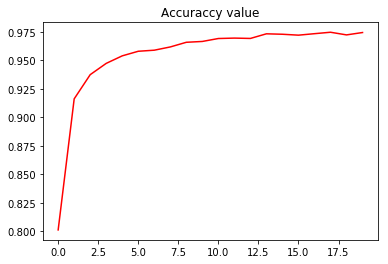

In [38]:
# One word: Amazing!
# 99% accuraccy!
# Comparing to SVM Classifier we have 5% improvement - so the question which
# model to choose is rather decided.
# Out of curiosity, let's see graph of history of our model learning. 
# (Although it was printed earlier)
plt.plot(hist.history['loss'], color='b')
plt.title('Loss value')
plt.show()
plt.plot(hist.history['acc'], color='r')
plt.title('Accuraccy value')
plt.show()

In [39]:
# Interesting thing, according to evaluation we have 99% accuraccy, but from our learning
# history we see 97.5% in last epoch.
# Still, our model is really good and I think I will save it for my descendants ^^
model.save('digit_recognizing_model.h5') 

In [40]:
# Let's make predictions for test data (using more accurate model)
output_file = "predictions.csv"

In [41]:
# Loading test data and making it suitable for Keras model
test_data = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
X_test = test_data.astype("float32")
X_test = X_test.reshape(-1, 28, 28, 1) / 255.

In [42]:
# Generating predictions
y_pred = model.predict(X_test, batch_size=64)
y_pred = np.argmax(y_pred, axis=1)

In [43]:
# Saving results
with open(output_file, 'w') as file:
    file.write('ImageId, Label\n')
    for i in range(len(y_pred)):
        file.write(''.join([str(i+1), ',', str(y_pred[i]), '\n']))